# Workshop 4: Neural Network for microRNA Classification

* Mirtron
* Dense Neural Network
* Recurrent Neural Network
* Covolutional Neural Network
* Challenge: build a RNN for ECG Anomaly Detection

In [1]:
# !pip3 install Bio
# !pip3 install biopython 

In [2]:
import csv
import os
import pandas as pd
from Bio import SeqIO, Seq
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, Dropout, Bidirectional, InputLayer, Flatten, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
import tensorflow as tf
import random as python_random
from tensorflow.keras.utils import normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, auc, roc_curve, matthews_corrcoef, precision_recall_curve

2022-07-12 23:56:18.413407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 23:56:18.413434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# To obtain reproducible result
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

### helper functions

In [4]:
def kmers_builder(sequences, ksize):
    kmers = []
    for seq in sequences:
        n_kmer = len(seq) - ksize + 1
        kmer = []
        for i in range(n_kmer):
            temp_kmer = seq[i:i + ksize]
            kmer.append(temp_kmer)
        kmers.append(kmer)
    return kmers

def one_hot_encoding(sequences, k_mer):
    encoded_data = []
    n = len(sequences)
    l = len(sequences[0])
    for i in range(n):
      data = []
      for k in range(l):
        seq = sequences[i][k]
        letter = [0 for _ in range(4**k_mer)]
        if seq == 0:
          data.append(letter)
        else:    
          index = seq-1
          letter[index] = 1
          data.append(letter)
      encoded_data.append(data)
    
    return np.array(encoded_data)

def label_encoding(labels):
    encoded_label = []
    n = len(labels)
    for i in range(n):
      label = labels.iloc[i]
      letter = [0.0,0.0]
      if label == 1:
        letter[1] = 1.0
      else:
        letter[0] = 1.0

      encoded_label.append(letter)
    
    return np.array(encoded_label)

def label_decoding(encoded_labels):
    decoded_label = []
    for i in range(len(encoded_labels)):
      decoded_label.append(encoded_labels[i][1])

    decoded_label = np.array(decoded_label)
    decoded_label = decoded_label.astype("float32", copy = False)
    return decoded_label

def evaluating(model, testing_inputs, testing_labels):
  predincting_labels = model.predict(testing_inputs)
  round_test = label_decoding(testing_labels)
  round_pre = np.round(label_decoding(predincting_labels))
  # Confusion matrix
  c = confusion_matrix(round_test, round_pre)

  # Precision 
  p = precision_score(round_test, round_pre)

  # Specificity
  tn, fp, fn, tp = confusion_matrix(round_test, round_pre).ravel()
  s =  tn / (tn+fp)

  # AUC
  fpr, tpr, _ = roc_curve(round_test, predincting_labels[:,1].ravel())
  auc_score = auc(fpr, tpr)

  model_precision, model_recall, _ = precision_recall_curve(round_test, predincting_labels[:,1].ravel())
  pr_auc_score = auc(model_recall, model_precision)

  # Recall
  r = recall_score(round_test, round_pre)

  # Accuracy
  a = accuracy_score(round_test,round_pre)

  # F1 score
  f1 = f1_score(round_test,round_pre)

  # MCC
  mcc = matthews_corrcoef(round_test, round_pre)

  # cohen kappa score
  cks = cohen_kappa_score(round_test,round_pre)

  result_dic = {
      'Recall': r,
      'Specificity': s,
      'AUC': auc_score,
      'F-1': f1,
      'Matthews Corrcoef': mcc
  }
  return result_dic

## Mirtron Data Preprocessing

What is MicroRNA:
> from wiki: *MicroRNAs (miRNAs) are a class of non-coding RNAs that play important roles in regulating gene expression. The majority of miRNAs are transcribed from DNA sequences into primary miRNAs and processed into precursor miRNAs, and finally mature miRNAs.*

What is Mirtron: 
> from wiki: *Mirtrons are a type of microRNAs that are located in the introns of the mRNA encoding host genes. These short hairpin introns formed via atypical miRNA biogenesis pathways. Mirtrons arise from the spliced-out introns and are known to function in gene expression.*

data: https://github.com/rorbachg/Mirtrons/tree/master/Data

In [5]:
miRBase_df = pd.read_csv( "data.csv")
putative_mirtron_df = pd.read_csv("testdata.csv")

In [6]:
miRBase_df.head()

,Unnamed: 0,hairpin_name,hairpin_seq,dotbracket,fe,arm5p,mature5p_seq,arm3p,mature3p_seq,class
0,1,hsa-let-7a-1,UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCAC...,(((((.(((((((((((((((((((((.....(((...((((.......,-34.2,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC,False
1,2,hsa-let-7a-2,AGGUUGAGGUAGUAGGUUGUAUAGUUUAGAAUUACAUCAAGGGAGA...,(((..(((.(((.(((((((((((((.........(((......))...,-25.2,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,hsa-let-7a-2-3p,CUGUACAGCCUCCUAGCUUUCC,False
2,3,hsa-let-7a-3,GGGUGAGGUAGUAGGUUGUAUAGUUUGGGGCUCUGCCCUGCUAUGG...,(((.(((((((((((((((((((((((((((...)))))).........,-34.1,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC,False
3,4,hsa-let-7b,CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCC...,(((((.(((((((((((((((((((((((.((((((.....)))))...,-46.7,hsa-let-7b-5p,UGAGGUAGUAGGUUGUGUGGUU,hsa-let-7b-3p,CUAUACAACCUACUGCCUUCCC,False
4,5,hsa-let-7c,GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCU...,((.((((((..(((.(((.(((((((((((((..((.(..((...)...,-31.6,hsa-let-7c-5p,UGAGGUAGUAGGUUGUAUGGUU,hsa-let-7c-3p,CUGUACAACCUUCUAGCUUUCC,False


In [7]:
mirtron_index = []
canonical_miRNA_index = []
for i in range(len(miRBase_df)):
  if miRBase_df.iloc[i]["class"] == False:
    canonical_miRNA_index.append(i)
  else:
    mirtron_index.append(i)

In [8]:
canonical_miRNA_df = miRBase_df.iloc[canonical_miRNA_index]
mirtron_df = miRBase_df.iloc[mirtron_index]

In [9]:
transcibed_seq_list = []

for i in range(len(putative_mirtron_df)):
  seq = putative_mirtron_df.iloc[i]["hairpin_seq"]
  transcibed_seq = Seq.transcribe(seq)
  transcibed_seq_list.append(transcibed_seq)

putative_mirtron_df["hairpin_seq"] = transcibed_seq_list

In [10]:
#For sequences contain mirtron set the column 'is_mirtron' to 1
canonical_miRNA_df = canonical_miRNA_df.assign(is_mirtron = 0)
mirtron_df = mirtron_df.assign(is_mirtron = 1)
putative_mirtron_df = putative_mirtron_df.assign(is_mirtron = 1)

## inspect the differences between two classes

In [11]:
print("minimum free energy for mirtrons :")
(putative_mirtron_df['fe'].sum() + mirtron_df['fe'].sum())/(len(putative_mirtron_df)+len(mirtron_df))

minimum free energy for mirtrons :


-28.646522781774582

In [12]:
print("minimum free energy for canonical miRNAs :")
canonical_miRNA_df['fe'].mean()

minimum free energy for canonical miRNAs :


-41.705728429985854

In [13]:
n = len(canonical_miRNA_df)
total_length = 0
for i in range(n):
  total_length += len(canonical_miRNA_df.iloc[i]["hairpin_seq"])

print("average hairpin sequence length of canonical miRNA", total_length/n)

average hairpin sequence length of canonical miRNA 84.22347949080623


In [14]:
n = len(mirtron_df)
total_length = 0
for i in range(n):
  total_length += len(mirtron_df.iloc[i]["hairpin_seq"])

print("average hairpin sequence length of mirtron", total_length/n)

average hairpin sequence length of mirtron 70.83333333333333


## Support Vector Machine

In [37]:
from sklearn import svm

df = pd.concat((mirtron_df,putative_mirtron_df),ignore_index=True)
df = pd.concat((df,canonical_miRNA_df), ignore_index=True)

# create a new column which store the length of the hairpin sequence
df['hairpin_seq_len'] = df['hairpin_seq'].str.len()

In [38]:
# shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

In [39]:
X = df[['fe','hairpin_seq_len']].to_numpy()
y = df['is_mirtron'].to_numpy()

train_test_ratio = 0.9

X_train = X[:int(len(X)*train_test_ratio)]
y_train = y[:int(len(y)*train_test_ratio)]
X_test = X[:int(len(X)*train_test_ratio)]
y_test = y[:int(len(y)*train_test_ratio)]

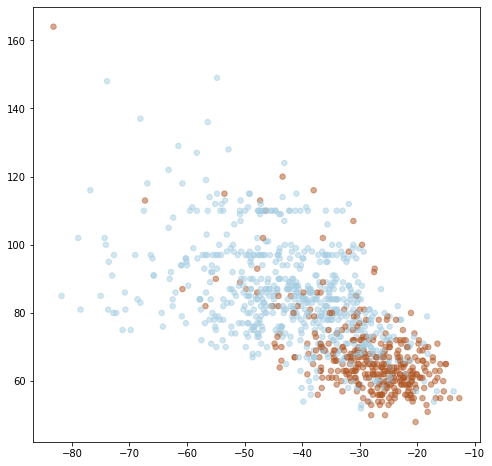

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:], s=30, alpha=0.5,cmap=plt.cm.Paired)

After visual inspection, we can find it is difficult to seperate two clusters using a SVC with linear kernel.  

For demonstration purpose, we are going to use the first 10 examples in our dataset to train a support vector machine

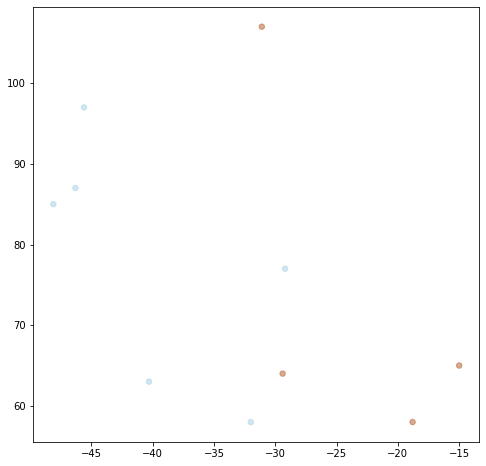

In [48]:
plt.figure(figsize=(8,8))
plt.scatter(X_train[:10, 0], X_train[:10, 1], c=y_train[:10], s=30, alpha=0.5,cmap=plt.cm.Paired)

In [49]:
clf = svm.SVC(kernel="linear")
clf.fit(X_train[:10], y_train[:10])

SVC(kernel='linear')

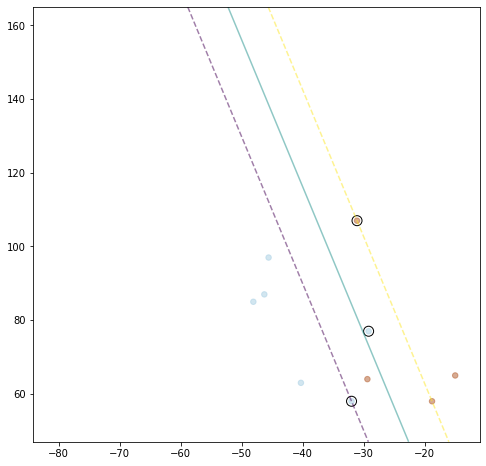

In [50]:
from sklearn.inspection import DecisionBoundaryDisplay

plt.figure(figsize=(8,8))
plt.scatter(X_train[:10, 0], X_train[:10, 1], c=y_train[:10], s=30, alpha=0.5,cmap=plt.cm.Paired)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:3, 0],
    clf.support_vectors_[:3, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

In [21]:
pred = np.round(clf.predict(X_test))

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

# Sensitivity
sensitivity = tp / (tp + fn)

# Specificity

specificity =  tn / (tn + fp)

# AUC
fpr, tpr, _ = roc_curve(y_test, pred)
auc_score = auc(fpr, tpr)

# F1 score
f1 = f1_score(y_test, pred)

# MCC
mcc = matthews_corrcoef(y_test, pred)

In [22]:
print(
'Recall: ', sensitivity,
'\nSpecificity: ', specificity,
'\nAUC: ', auc_score,
'\nF-1: ', f1,
'\nMatthews Corrcoef:', mcc
)

Recall:  0.8655913978494624 
Specificity:  0.7417840375586855 
AUC:  0.803687717704074 
F-1:  0.7497089639115251 
Matthews Corrcoef: 0.5862042979997333


## Prepare the data for NN

In [23]:
# df = mirtron_df.append(putative_mirtron_df,ignore_index=True)
# df = df.append(canonical_miRNA_df, ignore_index=True)

k_mer = 2
max_len = 80
miRNA_seq = df["hairpin_seq"]
miRNA_kmer = kmers_builder(miRNA_seq, k_mer)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(miRNA_kmer)

vocab_size = len(tokenizer.word_index)

training_canonical_miRNA_df = canonical_miRNA_df.sample(507, random_state=np.random.RandomState(42))
testing_canonical_miRNA_df = canonical_miRNA_df.drop(training_canonical_miRNA_df.index)

training_df = pd.concat((mirtron_df,training_canonical_miRNA_df), ignore_index=True)
testing_df = pd.concat((putative_mirtron_df,testing_canonical_miRNA_df), ignore_index=True)

training_df = training_df.reindex(np.random.permutation(training_df.index)) # shuffle the dataframe based on the index
testing_df = testing_df.reindex(np.random.permutation(testing_df.index))

training_sequences = training_df["hairpin_seq"]
training_labels = training_df["is_mirtron"]
training_labels = label_encoding(training_labels)

testing_sequences = testing_df["hairpin_seq"]
testing_labels = testing_df["is_mirtron"]
testing_labels = label_encoding(testing_labels)

# transfer the sequences into k-mer representation
training_sequences = kmers_builder(training_sequences,k_mer)
testing_sequences = kmers_builder(testing_sequences,k_mer)

# transfer the k-mer sequences into vetor
training_sequences = tokenizer.texts_to_sequences(training_sequences)
testing_sequences = tokenizer.texts_to_sequences(testing_sequences)

# different padded will affect the final result
training_sequences = one_hot_encoding(pad_sequences(training_sequences, maxlen=max_len, padding='pre',truncating='pre'), k_mer) 
testing_sequences = one_hot_encoding(pad_sequences(testing_sequences, maxlen=max_len, padding='pre',truncating='pre'), k_mer)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
num_epochs = 100   

## Dense Neural Network

In [24]:
def dnn_model(max_len, vocab_size):
    model = Sequential([
      InputLayer(input_shape=(max_len,vocab_size)),
      Flatten(),
      Dense(32,activation='relu'),
      Dense(16,activation='relu'),
      Dense(2, activation='softmax')
    ])  
    return model

model = dnn_model(max_len, vocab_size)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(training_sequences, training_labels, epochs=num_epochs, verbose=1, validation_split = 0.2, callbacks = [early_stop])

print("======================================================")

evaluating(model, testing_sequences, testing_labels)       

2022-07-12 23:56:29.109435: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-12 23:56:29.109546: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gadi-cpu-clx-1535.gadi.nci.org.au): /proc/driver/nvidia/version does not exist
2022-07-12 23:56:29.167156: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
19/19 [==============================] - 2s 11ms/step - loss: 0.5382 - val_loss: 0.3800
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.3219 - val_loss: 0.3105
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2347 - val_loss: 0.2775
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1710 - val_loss: 0.2429
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1131 - val_loss: 0.2224
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0696 - val_loss: 0.2160
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0409 - val_loss: 0.2213
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.2296
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.2358
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0202 - val_loss: 0.2422
Epoch 11

{'Recall': 0.8805970149253731,
 'Specificity': 0.96,
 'AUC': 0.98318407960199,
 'F-1': 0.917098445595855,
 'Matthews Corrcoef': 0.843117551361831}

Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. By adding dropout, our model can better generalize on real-word data.

In [25]:
def dnn_model(max_len, vocab_size):
    model = Sequential([
      InputLayer(input_shape=(max_len,vocab_size)),
      Flatten(),
      Dense(32,activation='relu'),
      Dropout(0.5),
      Dense(16,activation='relu'),
      Dropout(0.2),
      Dense(2, activation='softmax')
    ])  
    return model

model = dnn_model(max_len, vocab_size)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(training_sequences, training_labels, epochs=num_epochs, verbose=1, validation_split = 0.2, callbacks = [early_stop])

print("======================================================")

evaluating(model, testing_sequences, testing_labels)     

Epoch 1/100
19/19 [==============================] - 0s 9ms/step - loss: 0.6502 - val_loss: 0.4652
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.4606 - val_loss: 0.3595
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.3463 - val_loss: 0.2792
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2736 - val_loss: 0.2334
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 0.2270 - val_loss: 0.2131
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1670 - val_loss: 0.2037
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1398 - val_loss: 0.2048
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1085 - val_loss: 0.2091
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0860 - val_loss: 0.2139
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0759 - val_loss: 0.2250
Epoch 11/

{'Recall': 0.9154228855721394,
 'Specificity': 0.96,
 'AUC': 0.9884079601990049,
 'F-1': 0.9363867684478373,
 'Matthews Corrcoef': 0.8762079010210821}

## Recurrent Neural Network

In [26]:
def rnn_model(max_len,vocab_size):
    model = Sequential([
      InputLayer(input_shape=(max_len,vocab_size)),
      SimpleRNN(64, return_sequences = True),
      Dropout(0.2),
      SimpleRNN(32),
      Dropout(0.5),
      Dense(32,activation='relu'),
      Dropout(0.2),
      Dense(16,activation='relu'),
      Dense(2, activation='softmax')
    ])  
    return model

model = rnn_model(max_len, vocab_size)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(training_sequences, training_labels, epochs=num_epochs, verbose=1, validation_split = 0.2, callbacks = [early_stop])

print("======================================================")

evaluating(model, testing_sequences, testing_labels)  

Epoch 1/100
19/19 [==============================] - 3s 56ms/step - loss: 0.7292 - val_loss: 0.6542
Epoch 2/100
19/19 [==============================] - 1s 44ms/step - loss: 0.6288 - val_loss: 0.5534
Epoch 3/100
19/19 [==============================] - 1s 44ms/step - loss: 0.5357 - val_loss: 0.3951
Epoch 4/100
19/19 [==============================] - 1s 44ms/step - loss: 0.4202 - val_loss: 0.3041
Epoch 5/100
19/19 [==============================] - 1s 47ms/step - loss: 0.3289 - val_loss: 0.3483
Epoch 6/100
19/19 [==============================] - 1s 43ms/step - loss: 0.3575 - val_loss: 0.3090
Epoch 7/100
19/19 [==============================] - 1s 44ms/step - loss: 0.3107 - val_loss: 0.2693
Epoch 8/100
19/19 [==============================] - 1s 45ms/step - loss: 0.2775 - val_loss: 0.2431
Epoch 9/100
19/19 [==============================] - 1s 44ms/step - loss: 0.2558 - val_loss: 0.2684
Epoch 10/100
19/19 [==============================] - 1s 43ms/step - loss: 0.2490 - val_loss: 0.2522

{'Recall': 0.8606965174129353,
 'Specificity': 0.935,
 'AUC': 0.9629601990049751,
 'F-1': 0.8940568475452197,
 'Matthews Corrcoef': 0.797783007461263}

For input like DNA sequences, if the RNN model can take the input not only from one direction(5' to 3') but also from (3' to 5'), the RNN will perform better in most cases. Using "Bidirectional" function to wrap our RNN, our model will have knowledge before and after current word, not only just the word that come before it.  

Also, in the following example, we replace the SimpleRNN with a more complex implementation of RNN called LSTM(Long Short Term Memory).

In [27]:
def rnn_model(max_len,vocab_size):
    model = Sequential([
      InputLayer(input_shape=(max_len,vocab_size)),
      Bidirectional(LSTM(64, return_sequences = True)),
      Dropout(0.5),
      Bidirectional(LSTM(32)),
      Dropout(0.2),
      Dense(32,activation='relu'),
      Dropout(0.2),
      Dense(16,activation='relu'),
      Dense(2, activation='softmax')
    ])  
    return model

model = rnn_model(max_len, vocab_size)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(training_sequences, training_labels, epochs=num_epochs, verbose=1, validation_split = 0.2, callbacks = [early_stop])

print("======================================================")

evaluating(model, testing_sequences, testing_labels)  

Epoch 1/100
19/19 [==============================] - 8s 147ms/step - loss: 0.6177 - val_loss: 0.4230
Epoch 2/100
19/19 [==============================] - 2s 87ms/step - loss: 0.4089 - val_loss: 0.3041
Epoch 3/100
19/19 [==============================] - 2s 89ms/step - loss: 0.3293 - val_loss: 0.2620
Epoch 4/100
19/19 [==============================] - 2s 88ms/step - loss: 0.2719 - val_loss: 0.2452
Epoch 5/100
19/19 [==============================] - 2s 88ms/step - loss: 0.2476 - val_loss: 0.2816
Epoch 6/100
19/19 [==============================] - 2s 89ms/step - loss: 0.2772 - val_loss: 0.2281
Epoch 7/100
19/19 [==============================] - 2s 89ms/step - loss: 0.2159 - val_loss: 0.2248
Epoch 8/100
19/19 [==============================] - 2s 88ms/step - loss: 0.2081 - val_loss: 0.1948
Epoch 9/100
19/19 [==============================] - 2s 87ms/step - loss: 0.1894 - val_loss: 0.1935
Epoch 10/100
19/19 [==============================] - 2s 87ms/step - loss: 0.1785 - val_loss: 0.190

{'Recall': 0.9353233830845771,
 'Specificity': 0.965,
 'AUC': 0.9883582089552239,
 'F-1': 0.9494949494949495,
 'Matthews Corrcoef': 0.9006595127894311}

## Convolutional Neural Network

In [28]:
def cnn_model(max_len,vocab_size):
    model = Sequential([
      InputLayer(input_shape=(max_len,vocab_size)),
      Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'),
      Dropout(0.2),
      Conv1D(filters=64, kernel_size=7, padding ='same', activation='relu'),
      Dropout(0.2),
      Flatten(),
      Dense(32,activation='relu'),
      Dropout(0.2),
      Dense(16,activation='relu'),
      Dense(2, activation='softmax')
    ])  
    return model

model = cnn_model(max_len, vocab_size)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(training_sequences, training_labels, epochs=num_epochs, verbose=1, validation_split = 0.2, callbacks = [early_stop])

print("======================================================")

evaluating(model, testing_sequences, testing_labels)  

Epoch 1/100
19/19 [==============================] - 1s 17ms/step - loss: 0.5165 - val_loss: 0.3529
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 0.3088 - val_loss: 0.2322
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1899 - val_loss: 0.2369
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1441 - val_loss: 0.2310
Epoch 5/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1060 - val_loss: 0.2014
Epoch 6/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0811 - val_loss: 0.2361
Epoch 7/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0893 - val_loss: 0.1913
Epoch 8/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0432 - val_loss: 0.2371
Epoch 9/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0311 - val_loss: 0.2436
Epoch 10/100
19/19 [==============================] - 0s 10ms/step - loss: 0.0609 - val_loss: 0.2306

{'Recall': 0.9402985074626866,
 'Specificity': 0.975,
 'AUC': 0.9918656716417911,
 'F-1': 0.9569620253164558,
 'Matthews Corrcoef': 0.9157770234632778}

In [29]:
def cnn_model(max_len,vocab_size):
    model = Sequential([
      InputLayer(input_shape=(max_len,vocab_size)),
      Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
      Dropout(0.2),
      Conv1D(filters=64, kernel_size=2, padding ='same', activation='relu'),
      Dropout(0.2),
      Flatten(),
      Dense(32,activation='relu'),
      Dropout(0.2),
      Dense(16,activation='relu'),
      Dense(2, activation='softmax')
    ])  
    return model

model = cnn_model(max_len, vocab_size)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(training_sequences, training_labels, epochs=num_epochs, verbose=1, validation_split = 0.2, callbacks = [early_stop])

print("======================================================")

evaluating(model, testing_sequences, testing_labels)  

Epoch 1/100
19/19 [==============================] - 1s 17ms/step - loss: 0.4761 - val_loss: 0.2948
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2773 - val_loss: 0.2164
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.2107 - val_loss: 0.2123
Epoch 4/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1463 - val_loss: 0.2130
Epoch 5/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1184 - val_loss: 0.2434
Epoch 6/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0865 - val_loss: 0.1888
Epoch 7/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0615 - val_loss: 0.2091
Epoch 8/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0436 - val_loss: 0.2200
Epoch 9/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0471 - val_loss: 0.2274
Epoch 10/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0609 - val_loss: 0.2413
Epoch 11

{'Recall': 0.9601990049751243,
 'Specificity': 0.95,
 'AUC': 0.9932338308457711,
 'F-1': 0.9554455445544553,
 'Matthews Corrcoef': 0.9102669378785272}

## Challenge: Build a RNN to classifier ECG

In the last workshop, we saw how to use autoencoder to do anormally detection in ECG. In this challenge, we are going to modify the RNN we used above to detect if a rhythm is normal or not.

1. Change the input shape(use numpy array shape() function to inspect the input shape)
2. Change the output activation function from 'softmax' to 'sigmoid'
3. Change the loss function 

In [30]:
dataframe = pd.read_csv('../Workshop3_Dimensionality_Reduction_on_CITE_Seq/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [31]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [32]:
train_data.shape

TensorShape([3998, 140])

In [33]:
ecg_model = Sequential([
      InputLayer(input_shape=(80,16)),
      Bidirectional(LSTM(64, return_sequences = True)),
      Dropout(0.2),
      Bidirectional(LSTM(32)),
      Dropout(0.2),
      Dense(32,activation='relu'),
      Dropout(0.2),
      Dense(16,activation='relu'),
      Dense(1, activation='softmax')
    ])  
ecg_model.compile(loss='category_crossentropy',optimizer='adam',metrics=['accuracy'])
ecg_model.summary()
# ecg_model.fit(train_data, train_labels, epochs=num_epochs, verbose=1, validation_split = 0.2, callbacks = [early_stop])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 80, 128)          41472     
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 80, 128)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dropout_16 (Dropout)        (None, 32)               

In [34]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [35]:
pred = ecg_model.predict(test_data)
print_stats(np.round(pred[:,0]), test_labels)

ValueError: in user code:

    File "/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 80, 16), found shape=(None, 140)


benchmark result:
Accuracy = 0.99
Precision = 0.9875886524822695
Recall = 0.9946428571428572

## Summary:

1. manually extracted features from data 
2. used manually extracted features to train a SVM
3. build a 2-layer dense NN and use dropout to regularize our model
4. build a 2-layer recurrent NN and improve the performance by bidirectional LSTM
5. build a 2-layer convolutional NN to reduce the training speed